In this post, I explore patterns in traffic incidents in Travis County. Here are the questions that I explore:
1. Is traffic worse on weekends than on weekdays?
2. Which hour is the worst for traffic?
3. Which areas in Travis Counrty are the worst for collisions?
4. How do patterns in traffic change throughout the month?

## Setup Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import folium

import datetime as dt
import calendar as cal

In [2]:
data = pd.read_csv('Real-Time_Traffic_Incident_Reports.csv')

## Part 1: Data Exploration
---

In [3]:
data.head()

,Traffic Report ID,Published Date,Issue Reported,Location,Latitude,Longitude,Address,Status,Status Date
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,06/13/2018 06:35:59 AM +0000,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,ARCHIVED,06/13/2018 09:00:03 AM +0000
1,2664C206999E7419517EE39E177797576A52201B_15381...,09/29/2018 12:52:58 AM +0000,Traffic Hazard,"(30.380525,-97.737873)",30.380525,-97.737873,0 Mopac Sb To Research Sb Ramp,ARCHIVED,09/29/2018 01:35:03 AM +0000
2,5BB246A3223A89C7FB9B2EED9A2EBDA82141406D_15438...,12/03/2018 05:49:02 PM +0000,Crash Service,"(30.278372,-97.671971)",30.278372,-97.671971,5800 Techni Center Dr,ARCHIVED,12/03/2018 06:30:03 PM +0000
3,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,06/13/2018 10:15:36 AM +0000,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,ARCHIVED,06/13/2018 11:20:03 AM +0000
4,7FD2528A7609AAECB6AF825AC275F98CFDFFF8AD_15382...,09/29/2018 12:47:30 PM +0000,Traffic Hazard,"(30.281659,-97.728551)",30.281659,-97.728551,0 N Ih 35 Ud Sb To Mlk Ramp,ARCHIVED,09/29/2018 01:00:03 PM +0000


### Feature Engineering
I want to look at data only from 2018, so to do this I have to alter the 'Published Date' column so that I can convert it to date time and filter out non-2018 entries:

In [4]:
data['Day'] = data['Published Date'].apply(lambda x: x.split()[0])
data['Day'].head()

0    06/13/2018
1    09/29/2018
2    12/03/2018
3    06/13/2018
4    09/29/2018
Name: Day, dtype: object

In [5]:
data['Day'] = pd.to_datetime(data['Day'])
data = data[data['Day'].dt.year == 2018]
data.head()

,Traffic Report ID,Published Date,Issue Reported,Location,Latitude,Longitude,Address,Status,Status Date,Day
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,06/13/2018 06:35:59 AM +0000,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,ARCHIVED,06/13/2018 09:00:03 AM +0000,2018-06-13
1,2664C206999E7419517EE39E177797576A52201B_15381...,09/29/2018 12:52:58 AM +0000,Traffic Hazard,"(30.380525,-97.737873)",30.380525,-97.737873,0 Mopac Sb To Research Sb Ramp,ARCHIVED,09/29/2018 01:35:03 AM +0000,2018-09-29
2,5BB246A3223A89C7FB9B2EED9A2EBDA82141406D_15438...,12/03/2018 05:49:02 PM +0000,Crash Service,"(30.278372,-97.671971)",30.278372,-97.671971,5800 Techni Center Dr,ARCHIVED,12/03/2018 06:30:03 PM +0000,2018-12-03
3,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,06/13/2018 10:15:36 AM +0000,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,ARCHIVED,06/13/2018 11:20:03 AM +0000,2018-06-13
4,7FD2528A7609AAECB6AF825AC275F98CFDFFF8AD_15382...,09/29/2018 12:47:30 PM +0000,Traffic Hazard,"(30.281659,-97.728551)",30.281659,-97.728551,0 N Ih 35 Ud Sb To Mlk Ramp,ARCHIVED,09/29/2018 01:00:03 PM +0000,2018-09-29


I create a column for time of the day for later analysis. I extract the time from 'Published Date' and then convert to military time:

In [6]:
def extract_time(x):
    time = x.split()[1:3]
    #convert to military time
    if (time[1] == 'AM' and time[0].split(':')[0] == '12'):
        hour = '00'
        return hour + ':' + time[0].split(':')[1] + ':' + time[0].split(':')[2]
    if (time[1] == 'PM'):
        hour = int(time[0].split(':')[0])
        if hour != 12:
            hour += 12
        return str(hour) + ':' + time[0].split(':')[1] + ':' + time[0].split(':')[2]
    return time[0]
data['Time'] = data['Published Date'].apply(extract_time)
data['Time'] = pd.to_datetime(data['Time']).dt.time
data['Time'].head()

0    06:35:59
1    00:52:58
2    17:49:02
3    10:15:36
4    12:47:30
Name: Time, dtype: object

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70100 entries, 0 to 87428
Data columns (total 11 columns):
Traffic Report ID    70100 non-null object
Published Date       70100 non-null object
Issue Reported       70100 non-null object
Location             69935 non-null object
Latitude             70076 non-null float64
Longitude            70076 non-null float64
Address              70100 non-null object
Status               68407 non-null object
Status Date          70100 non-null object
Day                  70100 non-null datetime64[ns]
Time                 70100 non-null object
dtypes: datetime64[ns](1), float64(2), object(8)
memory usage: 6.4+ MB


Here, I look at the type of traffic incidents that occurs:

In [8]:
unique, counts = np.unique(data['Issue Reported'], return_counts=True)
traffic_types = pd.DataFrame({'Traffic Types':unique,'Count':counts})
traffic_types = traffic_types.sort_values(by=['Count'], ascending = False)
traffic_types.reset_index(drop=True)

,Traffic Types,Count
0,Traffic Hazard,20861
1,Crash Urgent,15701
2,Crash Service,11496
3,COLLISION,4914
4,Traffic Impediment,4898
5,TRFC HAZD/ DEBRIS,4287
6,zSTALLED VEHICLE,3215
7,COLLISION WITH INJURY,1626
8,LOOSE LIVESTOCK,1501
9,COLLISN/ LVNG SCN,1013


c:\users\ryan\appdata\local\programs\python\python36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\ryan\appdata\local\programs\python\python36\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


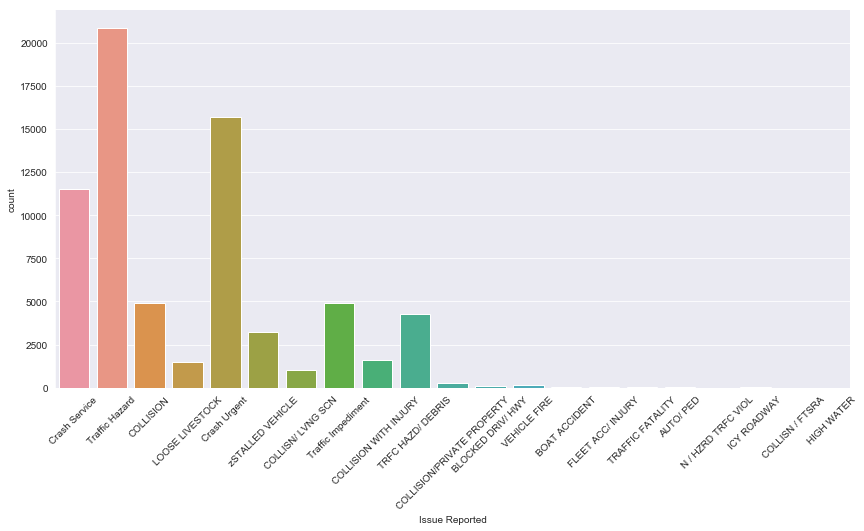

In [9]:
sns.set_style('darkgrid')
g = sns.factorplot('Issue Reported', data=data,kind='count', size=6, aspect=2)
g.set_xticklabels(rotation=45)

## Part 2: Data Cleaning
---
I have three concerns for data cleaning:
1. Values that are 0
2. Values that are missing or null
3. Unncessary columns

I'll go through cleaning each of these

In [10]:
print(data[data['Latitude']==0].count(),'\n------------------------')
print(data[data['Longitude']==0].count())

Traffic Report ID    141
Published Date       141
Issue Reported       141
Location               0
Latitude             141
Longitude            141
Address              141
Status               137
Status Date          141
Day                  141
Time                 141
dtype: int64 
------------------------
Traffic Report ID    141
Published Date       141
Issue Reported       141
Location               0
Latitude             141
Longitude            141
Address              141
Status               137
Status Date          141
Day                  141
Time                 141
dtype: int64


Latitude and longitude have the same amount of zeros, and I will infer that these values are 0 for the same entries. I'll just drop any value that is way out of bounds from a normal Travis County latitude/longitude:

In [11]:
#remove incorrect latitude and longitudes
data = data.drop(data[(data['Longitude'] > -90) |
                      (data['Longitude'] < -100) | 
                      (data['Latitude'] > 40) |
                      (data['Latitude'] < 20)].index)

In [12]:
missing = data.isnull().sum().sort_values(ascending=False)
pct = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
#creates dataframe with missing and pct missing
miss_data = pd.concat([missing, pct], axis=1, keys=['Missing','Percent'])
#shows columns with missing values
miss_data[miss_data['Missing']>0]

,Missing,Percent
Status,1689,2.414409
Longitude,24,0.034308
Latitude,24,0.034308
Location,24,0.034308


Drop missing data:

In [13]:
#gets rid of null values for longitude and by extension latitude
data = data[pd.notnull(data['Longitude'])]

Drop irrelevant columns:

In [14]:
data.drop(['Traffic Report ID', 
           'Published Date',
           'Location',
           'Address',
           'Status',
           'Status Date'],axis=1, inplace=True)

In [15]:
data = data.reset_index(drop=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69931 entries, 0 to 69930
Data columns (total 5 columns):
Issue Reported    69931 non-null object
Latitude          69931 non-null float64
Longitude         69931 non-null float64
Day               69931 non-null datetime64[ns]
Time              69931 non-null object
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 2.7+ MB


## Interactive Mapping
---

### Traffic incident map for 2018
You can click on each individual marker to see the type of traffic incident:

In [17]:
#Austin Coordinates: 30.2672° N, 97.7431° W
ATX_COOR = [30.2672, -97.7431]
MAX_RECORDS = 1000

#create empty map zoomed in on Austin
map1 = folium.Map(location = ATX_COOR, zoom_start = 12)

#add marker for every record in data
for i in range(0,MAX_RECORDS):
    folium.Marker(location = [data.iloc[i]['Latitude'],data.iloc[i]['Longitude']], popup=data.iloc[i]['Issue Reported']).add_to(map1)

display(map1)

The map is a little crowded, but zooming in and looking around it looks like the two main highways (Loop 1 and I-35) and downtown Austin have the highest accident rates. This makes sense because they are the roads that see the highest amount of traffic. The next plot will show clusters of where traffic incidents occur. You can click on the clusters to further explore certain areas:

### Cluster Map of traffic incidents in 2018

In [18]:
from folium.plugins import MarkerCluster

#create empty map zoomed in on Austin
map2 = folium.Map(location = ATX_COOR, zoom_start = 12)

mc = MarkerCluster()

#add marker for every record in data
for i in range(0,1500):
    mc.add_child(folium.Marker(location = [data.iloc[i]['Latitude'],data.iloc[i]['Longitude']],popup=data.iloc[i]['Issue Reported']))

map2.add_child(mc)
display(map2)

The first thing that jumped out was a huge amount of crashes at the intersection of I-35 and US-183 with 14/1500 accidents shown occuring at this one intersection in North Austin. Other major clusters include the intersection of TX-71 and I-35, downtown Austin, and the South Austin intersection of East Riverside Dr and I-35.

---

## Animated Heatmaps

I chose August for my analyses because it is commonly cited as the highest crash rate month. The graph below shows that this is the case for Austin as well, with May also having around as many accidents as well. 

Here is an interesting read on the most dangerous times to drive: https://www.bactrack.com/blogs/expert-center/35042821-the-most-dangerous-times-on-the-road

You can click on the slider on the bottom left to manually control the animated maps.

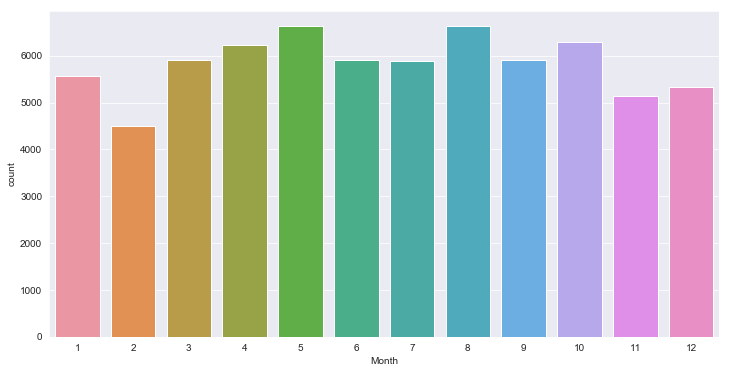

In [19]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x=data['Day'].dt.month)
ax.set_xlabel('Month')
plt.show()

Down below I create a temporary data frame to store all entries where I deemed the traffic incident as an "accident", and then sort by the day of the month. 

In [20]:
temp_df = data
temp_df = temp_df[temp_df['Day'].dt.month == 8]
temp_df = temp_df[(temp_df['Issue Reported'] == 'Crash Service') |
                  (temp_df['Issue Reported'] == 'Crash Urgent') |
                  (temp_df['Issue Reported'] == 'COLLISION') |
                  (temp_df['Issue Reported'] == 'TRFC HAZD/ DEBRIS') |
                  (temp_df['Issue Reported'] == 'COLLISION WITH INJURY') |
                  (temp_df['Issue Reported'] == 'COLLISION/ LVNG SCN') |
                  (temp_df['Issue Reported'] == 'COLLISION/PRIVATE PROPERTY') |
                  (temp_df['Issue Reported'] == 'VEHICLE FIRE') |
                  (temp_df['Issue Reported'] == 'AUTO/ PED') |
                  (temp_df['Issue Reported'] == 'Traffic Fatality')]
temp_df = temp_df.sort_values(by='Day')
temp_df = temp_df.reset_index(drop=True)
temp_df.tail()

,Issue Reported,Latitude,Longitude,Day,Time
3431,Crash Urgent,30.285397,-97.685534,2018-08-31,17:38:27
3432,Crash Urgent,30.328245,-97.663181,2018-08-31,09:11:03
3433,Crash Urgent,30.274125,-97.731982,2018-08-31,00:53:33
3434,Crash Urgent,30.328145,-97.665969,2018-08-31,13:24:51
3435,Crash Urgent,30.232393,-97.720396,2018-08-31,23:55:39


c:\users\ryan\appdata\local\programs\python\python36\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\ryan\appdata\local\programs\python\python36\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


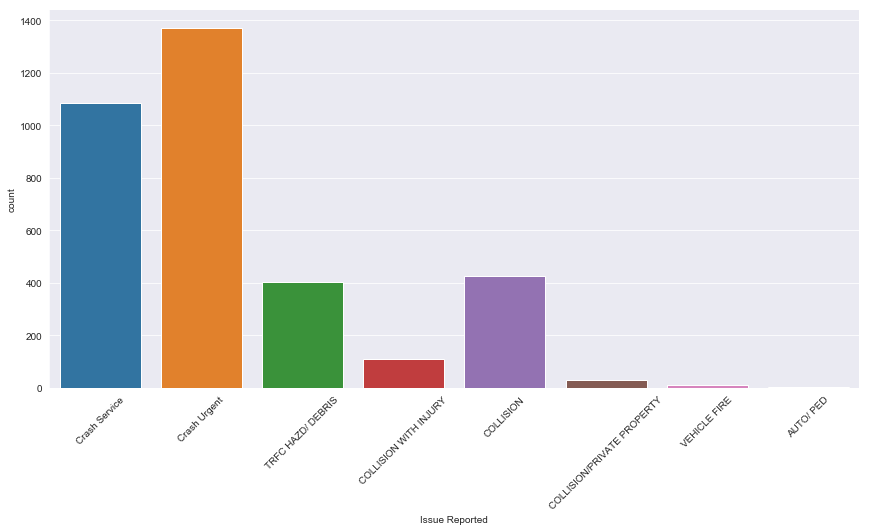

In [21]:
g = sns.factorplot('Issue Reported', data=temp_df,kind='count', size=6, aspect=2)
g.set_xticklabels(rotation=45)

Most accidents seem to be "urgent crash" followed by "crash service", but many of these names could be similar accidents with different codes to them. For this reason, analyzing the type of crash seems pretty futile, so I will stick to lumping these together and analyzing their patterns:

## August Accidents by Day of Month

In [22]:
heat_df = temp_df
heat_df = heat_df[['Latitude', 'Longitude', 'Day']]
heat_df = heat_df.dropna(axis=0)
heat_df['Weight'] = heat_df['Day'].dt.day.astype(float)
heat_df = heat_df.dropna(axis=0, subset=['Latitude','Longitude','Weight'])

In [23]:
from folium import plugins
from folium.plugins import HeatMap

ATX_COOR = [30.2672, -97.7431]
austin_heatmap = folium.Map(location = ATX_COOR, 
                            tiles = 'Stamen Terrain', 
                            zoom_start = 11)

heat_data = [[[row['Latitude'],row['Longitude']]
             for index, row in heat_df[heat_df['Weight']==i].iterrows()]
            for i in range(1,32)]

hm = plugins.HeatMapWithTime(data=heat_data,display_index=True,max_opacity=0.8)
hm.add_to(austin_heatmap)

austin_heatmap

It looks like the distribution of accidents from day to day is random, but it may be due to a day being a weekend or not. Some days tend to have accidents mainly concentrated on I-35 while others are evenly dispursed throughout the county.

## August Accidents by Day of Week

In [26]:
heat_df2 = temp_df
heat_df2 = heat_df2.dropna(axis = 0)
heat_df2['Weight'] = heat_df2['Day'].apply(lambda x: x.dayofweek).astype(float)
heat_df2 = heat_df2.dropna(axis=0, subset=['Latitude','Longitude','Weight'])

In [27]:
heat_df2.head()

,Issue Reported,Latitude,Longitude,Day,Time,Weight
0,Crash Service,30.219063,-97.718603,2018-08-01,18:53:23,2.0
1,Crash Urgent,30.172456,-97.799554,2018-08-01,14:15:34,2.0
2,Crash Urgent,30.252034,-97.741494,2018-08-01,16:09:22,2.0
3,Crash Urgent,30.252034,-97.741494,2018-08-01,16:07:08,2.0
4,Crash Service,30.160985,-97.816086,2018-08-01,17:07:48,2.0


In [28]:
austin_heatmap2 = folium.Map(location = ATX_COOR,
                            tiles = 'Stamen Terrain', 
                            zoom_start = 11)

heat_data2 = [[[row['Latitude'],row['Longitude']]
             for index, row in heat_df2[heat_df2['Weight']==i].iterrows()]
            for i in range(7)]


hm = plugins.HeatMapWithTime(data=heat_data2,display_index=True,max_opacity=0.8)
hm.add_to(austin_heatmap2)

austin_heatmap2

This shows accidents where 1 = Monday and 7 = Sunday. More accidents occur on weekdays, but strangely enough there is no major pattern change on weekends. It seems that the distribution of accidents could be more dependent on other factors not in the dataset such as weather. Lets see how time of the day affects accidents:

## August Accidents by Hour of Day

In [29]:
heat_df3 = temp_df
heat_df3 = heat_df3.dropna(axis = 0)
heat_df3['Weight'] = heat_df3['Time'].apply(lambda x: x.hour).astype(float)
heat_df3 = heat_df3.dropna(axis=0, subset=['Latitude','Longitude','Weight'])

In [30]:
ATX_COOR = [30.2672, -97.7431]
austin_heatmap3 = folium.Map(location = ATX_COOR,
                            tiles = 'Stamen Terrain', 
                            zoom_start = 11)

heat_data3 = [[[row['Latitude'],row['Longitude']]
             for index, row in heat_df3[heat_df3['Weight']==i].iterrows()]
            for i in range(24)]


hm = plugins.HeatMapWithTime(data=heat_data3,index=[i for i in range(24)],display_index=True,max_opacity=0.8)
hm.add_to(austin_heatmap3)

austin_heatmap3

This graph shows accidents by hour in military time starting with midnight-1am as "0". Here is what I can make out:
- The rate of accidents seems to stay strong until around 4am. 
- The hours of 5 and 6 seem to have very little accidents, which makes sense because very few cars are on the road. 
- The hours of 7 and 8 seem to be all centrally located around inner Austin where most people commute for their jobs. 
- There is almost no accidents until 12 when it picks up and is spread throughout Austin.
- These accidents increase steadily until they peak around the hour of 10pm. I expected there to be more crashes during rush hour, but it seems that there are the most accidents as night begins. 

## Summary
This project has a lot of potential for pattern exploration that I did not get into. My code is highly reusable for any location as long as you have coordinate points and the coordinates to your own city. There is also a lot more room to explore other questions such as which zip codes have the most accidents, which areas are more likely to have certain types of accidents, and traffic by hour on weekdays vs. weekends to name a few. I went through data exploration, data cleaning, and took on a more analytical role to uncover patterns in traffic without the help of machine learning. I hope you enjoyed the post, and feel free to reuse my code to uncover patterns in your own city!